In [ ]:
import numpy as np
from collections import defaultdict
from itertools import combinations, permutations
from bisect import bisect_left
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
a = np.array([18.85,16.93,19.29,18.31,17.27,18.64,17.82,19.00,19.58,18.04,17.27,19.19])
b = np.array([19.23,19.57,19.50,18.64,18.70,19.54,19.04,20.67,20.71,18.99,19.37,19.06])

The two-sample t-test gives `[-1.7348128 -0.4035205]` as a 95% confidence interval for the true difference in means between `a` and `b`. Following this result, we test various $\Delta_0 \in [-2, 0]$. For each $\Delta_0$, we collect all possible two-sample permutations. For each permutation, we compute the test statistic $t = |\bar X_1 - \bar X_2 - \Delta_0|$. The p-value associated with each $\Delta_0$ is the proportion of permutations such that $t \ge t_{obs}$, where $t_{obs}$ is the test statistic computed for the observed data $X_1 =$ `a` and $X_2 =$ `b`.

The goal is to compute a confidence interval for the plausible (i.e., $\alpha = 0.05$) values of the true difference in means $\delta$. We note that the $(\Delta_0, p)$ plot appears to be strictly decreasing. I.e., as $\Delta_0 \in [-2,0]$ increases, $p$ decreases.

In [6]:
def pval(a, b, delta0=0):
    a_shifted = a - delta0
    t_obs = np.mean(a_shifted) - np.mean(b)  # test statistic for observed
    data = np.concatenate((a_shifted,b))
    TOTAL = np.sum(data)
    n1, n2 = len(a), len(b)
    
    n_combos = 0
    #count = 0                               # num. permutations with t >= t_obs
    combos = combinations(range(n1+n2), n1)  # all possible ways to choose n1 from n1 + n2
    count_left = count_right = 0

    for combo in combos:
        group1 = [data[x] for x in combo]
        x1bar = np.mean(group1)
        x2bar = (TOTAL - (n1 * x1bar)) / n2
        t = x1bar - x2bar
        count_left += (t <= -abs(t_obs))
        count_right += (t >= abs(t_obs))
        n_combos += 1
        
    #p = (count_left + count_right)/n_combos  # proportion w/ "as or more extreme" test statistic
    p_values = np.array([(count_left + count_right), count_left, count_right])
    p_values = p_values / n_combos
    return delta0, p_values

In [20]:
def percent_change(old, new):
    return 100 * abs(new - old) / old

In [31]:
"""
Parameters:
x1 - data for group 1
x2 - data for group 2
start, end - initial bounds

This function performs a binary search on the interval [start, end]
corresponding to the (delta0, p_value) distribution.

Note that we assume the distribution is monotone DECREASING on [start, end].
I.e., the p-value associated with delta0 = start is larger than that for delta0 = end.

Due to convergence concerns, this function terminates when either:
(1) We have an approximation for delta0 such that the corresponding p-value is within
    a desired margin of alpha.
(2) The p-value from one iteration to the next has a percent change less than the desired
    threshold.
"""

def search(x1, x2, start, end, margin=0.0001, alpha=0.05, threshold=1):
    p = 0
    i = 0

    while (not i) or (abs(p - alpha) > margin):  # criterion (1)
        print("iteration", i)

        mid = (start + end) / 2
        print("delta0 =", mid, " in [", start, ",", end, "]")

        delta0, p_values = pval(x1, x2, delta0=mid)
        p_new = p_values[0]
        if p_new > alpha + margin:
            start = mid
        elif p_new < alpha - margin:
            end = mid
        
        # criterion (2)
        if p and percent_change(p, p_new) <= threshold:
            break

        p = p_new
        print("p =", p)
        print("---")
        
        i += 1
        
    return delta0, p

We use `search()` to find an upper bound for the 95% confidence interval. To get a general idea of $(\Delta_0, p)$ distribution looks like, we will compute $p$ for discrete evenly spaced $\Delta_0 \in [-3,1]$, a more conservative interval based on the earlier t-test.

In [22]:
res = []

# compute p for each delta0
for d in np.linspace(-3, 1, num=401):
    print("---")
    delta, p_values = pval(a, b, delta0=d)
    print("delta0 =", delta)
    print("p =", p_values[0])
    res.append((delta, p_values[0]))

res

---
delta0 = -3.0
p = 2.329747248309639e-05
---
delta0 = -2.99
p = 2.4406875934672407e-05
---
delta0 = -2.98
p = 2.6625682837824444e-05
---
delta0 = -2.97
p = 2.7735086289400465e-05
---
delta0 = -2.96
p = 2.9953893192552502e-05
---
delta0 = -2.95
p = 3.18028989451792e-05
---
delta0 = -2.94
p = 3.3282103547280556e-05
---
delta0 = -2.93
p = 3.291230239675522e-05
---
delta0 = -2.92
p = 3.4761308149381915e-05
---
delta0 = -2.91
p = 3.550091045043259e-05
---
delta0 = -2.9
p = 3.882912080516065e-05
---
delta0 = -2.89
p = 4.178753000936337e-05
---
delta0 = -2.88
p = 4.3266734611464726e-05
---
delta0 = -2.87
p = 4.4745939213566084e-05
---
delta0 = -2.86
p = 4.8813751869344814e-05
---
delta0 = -2.85
p = 5.399096797669957e-05
---
delta0 = -2.84
p = 5.473057027775025e-05
---
delta0 = -2.83
p = 5.7319178331427626e-05
---
delta0 = -2.82
p = 5.7688979481952964e-05
---
delta0 = -2.81
p = 5.953798523457966e-05
---
delta0 = -2.8
p = 6.471520134193441e-05
---
delta0 = -2.79
p = 7.100182090086518e-05
---

delta0 = -1.19
p = 0.7064185646094382
---
delta0 = -1.18
p = 0.7301398292110366
---
delta0 = -1.17
p = 0.7545737006296974
---
delta0 = -1.16
p = 0.7774814027001401
---
delta0 = -1.15
p = 0.801487414187643
---
delta0 = -1.14
p = 0.8266220587865493
---
delta0 = -1.13
p = 0.8507330938008014
---
delta0 = -1.1199999999999999
p = 0.8743267770054686
---
delta0 = -1.1099999999999999
p = 0.9004143991692787
---
delta0 = -1.0999999999999999
p = 0.9249066991697225
---
delta0 = -1.0899999999999999
p = 0.949140508165949
---
delta0 = -1.08
p = 0.9721931722873977
---
delta0 = -1.07
p = 0.9997995677764153
---
delta0 = -1.06
p = 0.975920028282392
---
delta0 = -1.05
p = 0.9543783716619899
---
delta0 = -1.04
p = 0.9285662513553212
---
delta0 = -1.03
p = 0.9026343154758824
---
delta0 = -1.02
p = 0.8801223006365018
---
delta0 = -1.01
p = 0.8556444228809285
---
delta0 = -1.0
p = 0.829070142403027
---
delta0 = -0.9899999999999998
p = 0.8069530751924076
---
delta0 = -0.98
p = 0.7831611785710588
---
delta0 = -0

delta0 = 0.33000000000000007
p = 0.00011833636816810864
---
delta0 = 0.33999999999999986
p = 0.00010428392444814574
---
delta0 = 0.3500000000000001
p = 9.429929338396157e-05
---
delta0 = 0.3599999999999999
p = 8.80126738250308e-05
---
delta0 = 0.3700000000000001
p = 7.76582416103213e-05
---
delta0 = 0.3799999999999999
p = 6.841321284718782e-05
---
delta0 = 0.3900000000000001
p = 6.212659328825704e-05
---
delta0 = 0.3999999999999999
p = 5.7688979481952964e-05
---
delta0 = 0.41000000000000014
p = 5.1032558772496855e-05
---
delta0 = 0.41999999999999993
p = 4.7334547267243456e-05
---
delta0 = 0.43000000000000016
p = 4.2157331159888706e-05
---
delta0 = 0.43999999999999995
p = 3.808951850410997e-05
---
delta0 = 0.4500000000000002
p = 3.4761308149381915e-05
---
delta0 = 0.45999999999999996
p = 3.106329664412852e-05
---
delta0 = 0.4700000000000002
p = 2.8104887439925803e-05
---
delta0 = 0.48
p = 2.6625682837824444e-05
---
delta0 = 0.4900000000000002
p = 2.5886080536773765e-05
---
delta0 = 0.5


[(-3.0, 2.329747248309639e-05),
 (-2.99, 2.4406875934672407e-05),
 (-2.98, 2.6625682837824444e-05),
 (-2.97, 2.7735086289400465e-05),
 (-2.96, 2.9953893192552502e-05),
 (-2.95, 3.18028989451792e-05),
 (-2.94, 3.3282103547280556e-05),
 (-2.93, 3.291230239675522e-05),
 (-2.92, 3.4761308149381915e-05),
 (-2.91, 3.550091045043259e-05),
 (-2.9, 3.882912080516065e-05),
 (-2.89, 4.178753000936337e-05),
 (-2.88, 4.3266734611464726e-05),
 (-2.87, 4.4745939213566084e-05),
 (-2.86, 4.8813751869344814e-05),
 (-2.85, 5.399096797669957e-05),
 (-2.84, 5.473057027775025e-05),
 (-2.83, 5.7319178331427626e-05),
 (-2.82, 5.7688979481952964e-05),
 (-2.81, 5.953798523457966e-05),
 (-2.8, 6.471520134193441e-05),
 (-2.79, 7.100182090086518e-05),
 (-2.78, 7.543943470716926e-05),
 (-2.77, 7.950724736294799e-05),
 (-2.76, 8.394486116925207e-05),
 (-2.75, 8.949187842713217e-05),
 (-2.74, 9.614829913658828e-05),
 (-2.73, 0.00010206511754499371),
 (-2.7199999999999998, 0.00010798193595339914),
 (-2.71, 0.000112049

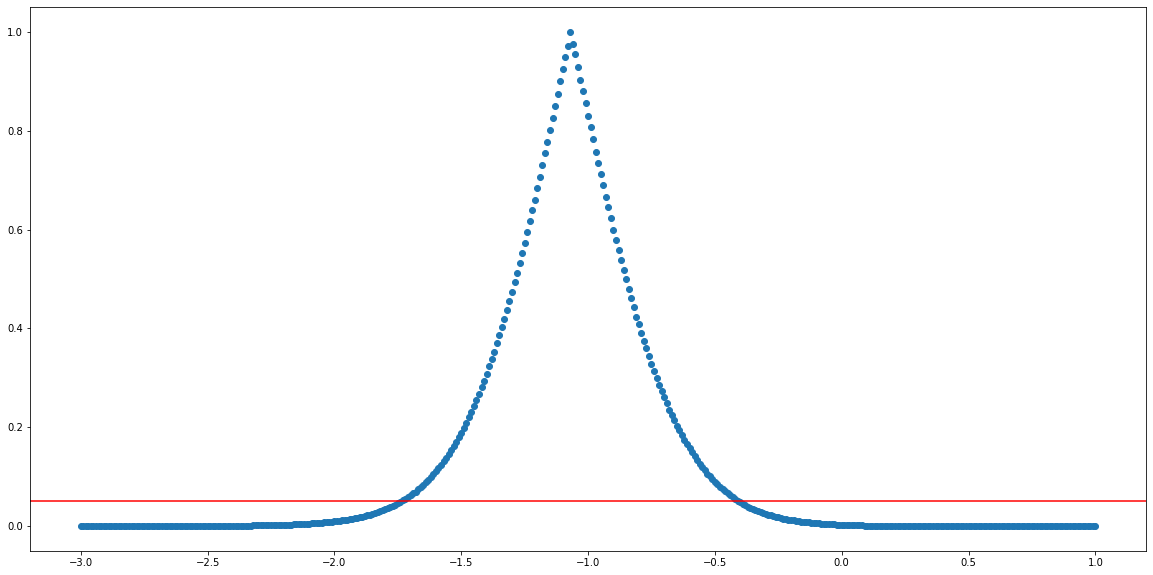

In [53]:
data = np.array(res)
x, y = data.T
plt.scatter(x,y)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.show()

We can see that, assuming monotonicity, the upper bound of the confidence interval is between -0.5 and -0.4. We verify that $p$ for $\Delta_0 = -0.5$ is greater than $p$ for $\Delta_0 = -0.4$.

In [12]:
pval(a, b, -0.5)

(-0.5, array([0.08907918, 0.04475888, 0.0443203 ]))

In [43]:
pval(a, b, -0.4)

(-0.4, [0.04812481232591611, 0.024178338823647748, 0.02394647350226836])

We now look for a good approximation for $\Delta$ in the interval $[-0.5, -0.4]$, bisecting the remaining candidate set each time until we find a sufficiently narrow interval that satisfies the earlier criteria.

In [17]:
search(a, b, -0.5, -0.4)

iteration 0
delta0 = -0.45  in [ -0.45 , -0.4 ]
p = 0.0662983200673334
---
iteration 1
delta0 = -0.42500000000000004  in [ -0.42500000000000004 , -0.4 ]
p = 0.056626540776493664
---
iteration 2
delta0 = -0.41250000000000003  in [ -0.41250000000000003 , -0.4 ]
p = 0.05226658521179991
---
iteration 3
delta0 = -0.40625  in [ -0.40625 , -0.4 ]
p = 0.05016352606876231
---
iteration 4
delta0 = -0.403125  in [ -0.40625 , -0.403125 ]
p = 0.0491214264265819
---
iteration 5
delta0 = -0.4046875  in [ -0.40625 , -0.4046875 ]
p = 0.049602167922264837
---
iteration 6
delta0 = -0.40546875  in [ -0.40625 , -0.4046875 ]
p = 0.04990910287720087
---


(-0.40546875, 0.04990910287720087)

After running for 7 iterations, we have an approximation $\hat\delta_0 = -0.40546875$ which returns a p-value within our specified margin of error of $\alpha$.

To verify that condition (2) works, let us set the threshold such that the search terminates after the iteration 1. From above, we see that iterations 0 and 1 return p-values of `0.0662983200673334` and `0.056626540776493664` respectively. This is a percent change of <15%, so if we set the threshold to 15, then the search should stop after iteration 1.

In [27]:
percent_change(0.0662983200673334, 0.056626540776493664)

14.588272042213067

In [32]:
search(a, b, -0.5, -0.4, threshold=15)

iteration 0
delta0 = -0.45  in [ -0.5 , -0.4 ]
p = 0.0662983200673334
---
iteration 1
delta0 = -0.42500000000000004  in [ -0.45 , -0.4 ]


(-0.42500000000000004, 0.0662983200673334)